# Clustering NBA Players

We need to now cluster NBA players. We will use the same Expectation-maximalization with a Gaussian Mixture Model as we did with NCAA clusters. This will prove especially useful, because with eventual projections, having a probabilistic view of the player's potential play type will create a more vivid picture of future ability. Also, as before, it gives us a less rigid view of how each player plays in the NBA

# Feature Selection

Here, our features not only need to be able to tell the full spectrum of player ability, but also be relatively sparse. They also need to reflect what we want to know about a prospect when we predict their future performance. This is because we'll have to eventually predict each feature using NCAA features, combine measures, and auxillary stats, and we don't want to have to create an impossibly large number of models. Because of that, we'll attempt to keep the amount of features small while still capturing the distribution.

Also, we want these clusters to reflect the modern NBA (though we have data stretching back 20 years for eventual matching). Many like to interpret the league as we know it to have started at the bubble, in the 2019-2020 season. That conference finals featured the same teams we just had in 2023, and can be seen as the start of the current era. Also, that season was the successor of the ultra spread pick-and-roll Harden and Westbrook Eras and Three-point revolution that preceded it. While each is present in the modern game, it is not the only thing anymore and we don't want our clusters to equally weigh those.

We'll look to drop features that are told more fully in other features, as well as features that are not relevant to clustering.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 150)

import os
import sys


current = os.path.dirname(os.path.realpath("nba_clusters"))
parent = os.path.dirname(current)

nba = pd.read_csv(parent + "/player_data/nba_players.csv")

In [2]:
# we need to train it on set conditions so that we have full information
nba_c = nba[(nba.Season.between(np.max(nba.Season)-4, np.max(nba.Season))) & (nba.MP>10) & (nba.G>20)].reset_index(drop=True)
nba_c = nba_c.drop(["Player", "Pos", "Age", "Tm", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", 
                    "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "ORB", "DRB", "TRB", 
                    "AST", "STL", "BLK", "TOV", "PF", "PTS", "ORtg", "DRtg", "Season", "PER", 
                    "OWS", "DWS", "WS", "WS/48", "BPM", "VORP", "dunk_#", "heave_Att.", 
                    "heave_#", "Player-additional", 
                    # "GMM_Primary_Cluster", "GMM_Secondary_Cluster", "Full Role"
                   ], axis=1)

# run a heatmap corrplot to see which features we should remove next
nba_c.corr().style.background_gradient(cmap='coolwarm')

,FT%,AST_2_TOV,AST_2_FG,PPP,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OBPM,DBPM,Dist.,2P_prop,0-3_prop,3-10_prop,10-16_prop,16-3P_prop,3P_prop,2P_fg%,0-3_fg%,3-10_fg%,10-16_fg%,16-3P_fg%,3P_fg%,2P_%astd,3P_%astd,dunk_%FGA,corner_%3PA,corner_3P%
FT%,1.000000,0.211018,0.018903,0.167040,0.075419,0.380898,-0.206249,-0.478421,-0.323371,-0.411123,0.202282,-0.071566,-0.382034,-0.242853,0.271851,0.283226,-0.223094,0.491345,-0.380895,-0.533149,-0.264087,0.285146,0.310407,0.380898,-0.257666,-0.132759,0.067429,0.192828,0.254075,0.403257,-0.250098,0.144114,-0.458394,-0.118918,0.372451
AST_2_TOV,0.211018,1.000000,0.679786,-0.139515,-0.190888,0.216934,-0.267210,-0.421654,-0.370997,-0.419508,0.556292,0.257865,-0.376560,-0.075619,-0.072166,0.137180,0.142763,0.309939,-0.216935,-0.370799,-0.109301,0.264051,0.207833,0.216934,-0.245432,-0.156639,0.009921,0.098098,0.117664,0.175360,-0.418186,-0.026331,-0.401628,-0.056172,0.182860
AST_2_FG,0.018903,0.679786,1.000000,-0.397269,-0.178855,-0.054416,0.006301,-0.217524,-0.162072,-0.195419,0.737000,0.368055,-0.223577,0.622438,-0.055843,0.024716,0.289347,0.014764,0.054417,-0.091329,0.126357,0.186431,0.082778,-0.054416,-0.172341,-0.173419,0.013335,0.033890,0.037256,-0.017189,-0.483153,-0.173248,-0.221018,-0.117505,0.006914
PPP,0.167040,-0.139515,-0.397269,1.000000,0.921126,-0.122532,0.265546,0.272764,0.219649,0.264982,-0.270265,-0.243591,0.273233,-0.438671,0.033696,0.586781,0.126609,-0.181228,0.122526,0.246121,-0.019043,-0.109485,-0.141103,-0.122532,0.657353,0.545007,0.332336,0.138432,0.040088,0.107065,0.368256,-0.065513,0.391791,-0.005322,0.046436
TS%,0.075419,-0.190888,-0.178855,0.921126,1.000000,-0.282051,0.410659,0.389796,0.332198,0.389376,-0.132617,-0.172576,0.353604,-0.057859,0.015350,0.569442,0.256074,-0.352539,0.282045,0.408100,0.112080,-0.139046,-0.212631,-0.282051,0.747443,0.568988,0.377009,0.121299,0.004821,0.018818,0.316448,-0.179041,0.508312,-0.044512,-0.038864
3PAr,0.380898,0.216934,-0.054416,-0.122532,-0.282051,1.000000,-0.609003,-0.672775,-0.508952,-0.616332,-0.093406,-0.038720,-0.467440,-0.319984,-0.150379,-0.139436,-0.224632,0.946216,-1.000000,-0.778002,-0.712704,-0.236698,-0.002241,1.000000,-0.374669,-0.214617,-0.202865,-0.035620,0.123459,0.504485,-0.016769,0.379692,-0.597053,0.070120,0.462001
FTr,-0.206249,-0.267210,0.006301,0.265546,0.410659,-0.609003,1.000000,0.483528,0.422788,0.482069,0.089490,-0.022469,0.366736,0.245039,0.225680,0.290065,0.196758,-0.630803,0.609006,0.599325,0.410449,-0.028348,-0.159741,-0.609003,0.338319,0.213437,0.079019,-0.035353,-0.182430,-0.348625,0.031643,-0.347916,0.508722,-0.137128,-0.291218
ORB%,-0.478421,-0.421654,-0.217524,0.272764,0.389796,-0.672775,0.483528,1.000000,0.699691,0.878514,-0.310350,-0.096806,0.656426,0.183737,-0.160268,0.073030,0.263249,-0.786193,0.672775,0.800688,0.450015,-0.245437,-0.365734,-0.672775,0.528655,0.281060,0.153208,-0.084314,-0.213239,-0.490297,0.397594,-0.223334,0.700230,-0.002934,-0.480816
DRB%,-0.323371,-0.370997,-0.162072,0.219649,0.332198,-0.508952,0.422788,0.699691,1.000000,0.955270,-0.119120,-0.102452,0.551839,0.189068,0.100285,0.256657,0.373141,-0.554764,0.508946,0.537442,0.346694,-0.082371,-0.188551,-0.508952,0.416204,0.299565,0.184471,-0.052747,-0.097501,-0.313788,0.312170,-0.144254,0.500472,-0.160280,-0.330101
TRB%,-0.411123,-0.419508,-0.195419,0.264982,0.389376,-0.616332,0.482069,0.878514,0.955270,1.000000,-0.205979,-0.110633,0.639352,0.202977,0.001379,0.206532,0.364873,-0.693590,0.616327,0.688264,0.415783,-0.155432,-0.276652,-0.616332,0.500504,0.320227,0.189141,-0.068055,-0.150914,-0.409835,0.373593,-0.190409,0.623935,-0.108503,-0.418790


For the NBA clustering, we will consider the first batch of highly correlated features to be >.5. That is because as explained earlier, we need to keep the number of features for clustering to the essentials, to get a generalized model that we don't have to predict too many features for.

These highly correlated pairs are as follows:
- AST%, AST to FG, and AST to TOV: Drop ast to tov as it is more skill based
- PPP, TS%, OBPM: Drop TS% & OBPM (PPP is our engineered feature we want to keep)
- 3pt ATr, Distance, and 3P Prop: Drop 3AR and Distance (Prop fits with our other proportional features)
- ORB%, DRB%, TRB%: Drop TRB% as it tells less
- DBPM and STL%: Drop DBPM (also removes high correlation with BLK%)
- Shot proportions: drop 2pt prop
- Dunk% of FGA and 0-3 prop: Remove dunk as it has more higher correlations

Other notes:
- We drop FTr as players that score in the paint draw more fouls, and measures of paint scoring are already present.
- We note that TRB%, BLK%, and 0-3 prop are correlated. We drop 0-3 prop reluctantly

Also, in this model, we will drop all FG% as it just says how good players are at shooting, and a generalized efficiency metric in PPP is just as effective.

Last, we want to combine 0-3 prop and 3-10 prop as well as 10-16 prop and 16-3P prop into a close prop and mid prop to further reduce features. Along with those feature creations, we want to change corner 3s, assisted 3s, and assisted 2s as proportions of 2 points in general

After this, we will run the corrplot one more time for examination.

In [3]:
nba_c["close_prop"] = nba_c["0-3_prop"] + nba_c["3-10_prop"]
nba_c["mid_prop"] = nba_c["10-16_prop"] + nba_c["16-3P_prop"]

nba_c["2P_%astd"] = nba_c["2P_prop"] * nba_c["2P_%astd"]
nba_c["3P_%astd"] = nba_c["3P_prop"] * nba_c["3P_%astd"]

nba_c["corner_%3PA"] = nba_c["3P_prop"] * nba_c["corner_%3PA"]
nba_c["3P_prop_not_corner"] = nba_c["3P_prop"] - nba_c["corner_%3PA"]

nba_c = nba_c.drop(["AST_2_TOV", "TS%", "OBPM", "FTr", "TRB%", "3PAr", "Dist.", "2P_prop", "DBPM", 
                    "dunk_%FGA", "2P_fg%", "0-3_fg%", "3-10_fg%", "10-16_fg%", "16-3P_fg%", 
                    "3P_fg%", "corner_3P%", "FT%", "0-3_prop", "3-10_prop", "10-16_prop", 
                    "16-3P_prop", "3P_prop"], axis=1)
nba_c.corr().style.background_gradient(cmap='coolwarm')

,AST_2_FG,PPP,ORB%,DRB%,AST%,STL%,BLK%,TOV%,USG%,2P_%astd,3P_%astd,corner_%3PA,close_prop,mid_prop,3P_prop_not_corner
AST_2_FG,1.000000,-0.397269,-0.217524,-0.162072,0.737000,0.368055,-0.223577,0.622438,-0.055843,-0.277405,-0.154319,-0.158148,-0.018932,0.152187,0.009051
PPP,-0.397269,1.000000,0.272764,0.219649,-0.270265,-0.243591,0.273233,-0.438671,0.033696,0.341984,-0.076887,-0.061440,0.181558,-0.140018,-0.126476
ORB%,-0.217524,0.272764,1.000000,0.699691,-0.310350,-0.096806,0.656426,0.183737,-0.160268,0.771964,-0.550622,-0.375019,0.798539,-0.340941,-0.675653
DRB%,-0.162072,0.219649,0.699691,1.000000,-0.119120,-0.102452,0.551839,0.189068,0.100285,0.585624,-0.421686,-0.394501,0.554123,-0.150456,-0.455908
AST%,0.737000,-0.270265,-0.310350,-0.119120,1.000000,0.293887,-0.292277,0.397223,0.567557,-0.430396,-0.294954,-0.385660,-0.098078,0.402358,0.072450
STL%,0.368055,-0.243591,-0.096806,-0.102452,0.293887,1.000000,-0.034664,0.229388,-0.007780,-0.141702,-0.083459,0.007174,0.028916,0.017015,-0.053217
BLK%,-0.223577,0.273233,0.656426,0.551839,-0.292277,-0.034664,1.000000,0.104898,-0.122362,0.622642,-0.367187,-0.290341,0.553660,-0.234573,-0.454597
TOV%,0.622438,-0.438671,0.183737,0.189068,0.397223,0.229388,0.104898,1.000000,-0.051644,0.104583,-0.355978,-0.277906,0.346352,-0.090304,-0.271743
USG%,-0.055843,0.033696,-0.160268,0.100285,0.567557,-0.007780,-0.122362,-0.051644,1.000000,-0.235204,-0.316465,-0.480817,-0.065542,0.448969,0.046831
2P_%astd,-0.277405,0.341984,0.771964,0.585624,-0.430396,-0.141702,0.622642,0.104583,-0.235204,1.000000,-0.576634,-0.350267,0.799403,-0.209595,-0.771537


With our finalized features, we can begin the clustering. We also can be aware that these are the features which we will eventually need to predict to cluster prospects' projected roles.

## PCA Decomposition

As with last time, to generalize our results as well as make it easier to visualize (eventually), we need to use principal components to cluster.

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
nba_c_columns = nba_c.columns
nba_c = scaler.fit_transform(nba_c)
nba_c = pd.DataFrame(nba_c, columns=nba_c_columns)

pca = PCA().fit(nba_c)

np.cumsum(pca.explained_variance_ratio_)

array([0.36069113, 0.58083189, 0.70972889, 0.7689016 , 0.8246854 ,
       0.87123327, 0.90911929, 0.93788473, 0.95950073, 0.97686547,
       0.98853078, 0.99583976, 0.99834853, 0.99999965, 1.        ])

With 6 components, we can account for just over 87% of the variance in the distribution. Therefore, we will reduce the structure of the data to 6 dimensions.

In [5]:
pca = PCA(n_components=6).fit(nba_c)
pca_c = pca.transform(nba_c)

## GMM Clustering

After finding the principal components, we need to create our Gaussian Mixture Model for clustering with expectation-maximalization.

As part of this, we need to know the number of components (clusters) to have. To do this, we'll see which number of components minimizes the BIC score.

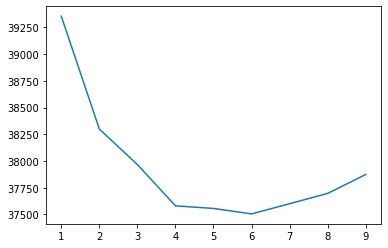

In [6]:
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
%matplotlib inline

gauss_bic = []
gauss_comp = []

for i in np.arange(1, 10):
    gauss = GaussianMixture(n_components=i, covariance_type = "full", random_state=9)
    bic = gauss.fit(pca_c).bic(pca_c)
    gauss_bic += [bic]
    gauss_comp += [i]
    
plt.plot(gauss_comp, gauss_bic)
plt.xticks(gauss_comp);

In this, the BIC begins to increase again after 6 components, indicating that we need a slightly simpler role structure than our last model. This makes sense as the NBA is full of archetypal role players with less room for variance. However, let's examine this to understand what the roles are.

In [7]:
gaussian = GaussianMixture(n_components=6, covariance_type="full",
                           n_init=5, random_state=9)
gaussian.fit(pca_c)

GaussianMixture(n_components=6, n_init=5, random_state=9)

In [8]:
clusters = pd.DataFrame(np.round(gaussian.predict_proba(pca_c), 3), 
                        columns=["P(1)", "P(2)", "P(3)", "P(4)", "P(5)", "P(6)"])

In [9]:
arank = clusters.apply(np.argsort, axis=1)
brank = clusters.apply(np.sort, axis=1)

clusters["Primary Cluster"] = (arank.values[:, ::-1][:,:2][:,0]+1)
clusters["P(Primary Cluster)"] = brank.str[-1]
clusters["Secondary Cluster"] = (arank.values[:, ::-1][:,:2][:,1]+1)
clusters["P(Secondary Cluster)"] = brank.str[-2]

clusters.loc[clusters["P(Secondary Cluster)"] < .2, "Secondary Cluster"] = 0

In [10]:
nba_c = nba_c.assign(GMM_Primary_Cluster =  clusters["Primary Cluster"])

nba_c = nba_c.assign(GMM_Secondary_Cluster = clusters["Secondary Cluster"])

In [11]:
clusters["Primary Cluster"].value_counts()

6    551
1    409
4    409
2    260
3    192
5    145
Name: Primary Cluster, dtype: int64

As we did in the last exercise, in this exercise we will examine the true clusters (individuals with no secondary clusters) to derive the true meaning of each cluster.

In [12]:
nba_c[nba_c.GMM_Secondary_Cluster==0].groupby("GMM_Primary_Cluster").mean()

,AST_2_FG,PPP,ORB%,DRB%,AST%,STL%,BLK%,TOV%,USG%,2P_%astd,3P_%astd,corner_%3PA,close_prop,mid_prop,3P_prop_not_corner,GMM_Secondary_Cluster
GMM_Primary_Cluster,,,,,,,,,,,,,,,,
1,-0.612900,0.193934,-0.445260,-0.459275,-0.800098,-0.562148,-0.443459,-0.697527,-0.700592,-0.392987,1.271006,1.331478,-0.769433,-0.565850,0.727771,0.0
2,1.789168,-1.309798,-0.408543,-0.443010,0.910506,1.421483,-0.334348,1.338826,-0.482831,-0.404139,-0.164614,-0.028517,0.079308,0.162007,-0.194364,0.0
3,-0.311019,0.867143,2.135839,1.360777,-0.677486,-0.311364,1.597865,0.648038,-0.606038,2.020016,-1.657884,-1.198731,2.076035,-0.732179,-1.742079,0.0
4,-0.426275,0.383588,0.629346,0.662823,-0.526339,-0.083458,0.761315,-0.022076,-0.225747,0.570010,0.000078,-0.053848,0.485587,-0.653233,-0.218301,0.0
5,0.011143,0.361312,0.343978,1.348632,1.039738,0.057992,0.450091,0.063286,1.657526,0.288684,-0.870498,-0.952263,0.241860,0.923667,-0.429254,0.0
6,0.190736,-0.107877,-0.734131,-0.683518,0.604426,-0.194951,-0.608960,-0.202392,0.647068,-0.733573,0.001775,-0.264470,-0.624557,0.762655,0.495888,0.0


#### Cluster Analysis

This is what the numbers tell us:

- 1) Highest three point numbers, lowest usage, low passing numbers, low rebounding numbers
- 2) Highest AST2FG and Steals, second highest AST%, highest TOV%, low usage, lower rebounding stats
- 3) Highest PPP, Highest rebounding numbers and block numbers, highest assisted 2Ps and close prop, lowest 3 numbers
- 4) good rebounding, decent efficiency, bad creation, good blocks, higher 2pt assisted, second highest corner 3p prop
- 5) Highest Usage, higher DRB%, highest AST% but also middle AST2FG, low 3P assisted, highest mid proportion, higher blocks and steals
- 6) higher usage, low rebounding numbers, high non-corner threes, good mid prop 

This is what we infer:

- 1) Floor-Spacer
- 2) Pass-First Playmaker
- 3) Rim Runner
- 4) Skilled Big
- 5) Interior Offensive Hub
- 6) Combo Guard

As we did in the NCAA clusters, to assign modern labels to all years of NBA data, we just need to predict the created and fit models on the full dataset.

In [13]:
nba_2 = nba.copy()

nba_2["close_prop"] = nba_2["0-3_prop"] + nba_2["3-10_prop"]
nba_2["mid_prop"] = nba_2["10-16_prop"] + nba_2["16-3P_prop"]

nba_2["2P_%astd"] = nba_2["2P_prop"] * nba_2["2P_%astd"]
nba_2["3P_%astd"] = nba_2["3P_prop"] * nba_2["3P_%astd"]

nba_2["corner_%3PA"] = nba_2["3P_prop"] * nba_2["corner_%3PA"]
nba_2["3P_prop_not_corner"] = nba_2["3P_prop"] - nba_2["corner_%3PA"]

nba_c2 = nba_2.drop(["Player", "Pos", "Age", "Tm", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", 
                    "3PA", "3P%", "2P", "2PA", "2P%", "FT", "FTA", "ORB", "DRB", "TRB", 
                    "AST", "STL", "BLK", "TOV", "PF", "PTS", "ORtg", "DRtg", "Season", "PER", 
                    "OWS", "DWS", "WS", "WS/48", "BPM", "VORP", "dunk_#", "heave_Att.", 
                    "heave_#", "Player-additional", "AST_2_TOV", "TS%", "OBPM", "FTr", 
                    "TRB%", "3PAr", "Dist.", "2P_prop", "DBPM", "dunk_%FGA", "2P_fg%", 
                    "0-3_fg%", "3-10_fg%", "10-16_fg%", "16-3P_fg%", "3P_fg%", "corner_3P%", 
                    "FT%", "0-3_prop", "3-10_prop", "10-16_prop", "16-3P_prop", "3P_prop",
                    # "GMM_Primary_Cluster", "GMM_Secondary_Cluster"
                    ], axis=1)

nba_c2_columns = nba_c2.columns
nba_c2 = scaler.transform(nba_c2)
nba_c2 = pd.DataFrame(nba_c2, columns=nba_c2_columns)

pca_c2 = pca.transform(nba_c2)

clusters_2 = pd.DataFrame(np.round(gaussian.predict_proba(pca_c2), 3), 
                          columns=["P(1)", "P(2)", "P(3)", "P(4)", "P(5)", "P(6)"])

arank_2 = clusters_2.apply(np.argsort, axis=1)
brank_2 = clusters_2.apply(np.sort, axis=1)

clusters_2["Primary Cluster"] = (arank_2.values[:, ::-1][:,:2][:,0]+1)
clusters_2["P(Primary Cluster)"] = brank_2.str[-1]
clusters_2["Secondary Cluster"] = (arank_2.values[:, ::-1][:,:2][:,1]+1)
clusters_2["P(Secondary Cluster)"] = brank_2.str[-2]

clusters_2.loc[clusters_2["P(Secondary Cluster)"] < .2, "Secondary Cluster"] = 0

nba_2 = nba_2.assign(GMM_Primary_Cluster =  clusters_2["Primary Cluster"])
nba_2 = nba_2.assign(GMM_Primary_Cluster_Prob =  clusters_2["P(Primary Cluster)"])

nba_2 = nba_2.assign(GMM_Secondary_Cluster =  clusters_2["Secondary Cluster"])
nba_2 = nba_2.assign(GMM_Secondary_Cluster_Prob =  clusters_2["P(Secondary Cluster)"])

nba_2["GMM_Primary_Cluster"] = nba_2["GMM_Primary_Cluster"].replace({1: "Floor Spacer",
                                                                     2: "Pass-First Playmaker",
                                                                     3: "Rim Runner",
                                                                     4: "Skilled Big",
                                                                     5: "Interior Offensive Hub",
                                                                     6: "Scoring Guard"
                                                                     })

nba_2["GMM_Secondary_Cluster"] = nba_2["GMM_Secondary_Cluster"].replace({0: "None",
                                                                         1: "Floor Spacer",
                                                                         2: "Pass-First Playmaker",
                                                                         3: "Rim Runner",
                                                                         4: "Skilled Big",
                                                                         5: "Interior Offensive Hub",
                                                                         6: "Scoring Guard"
                                                                         })

In [14]:
nba_2["Full Role"] = nba_2["GMM_Primary_Cluster"] + " " + nba_2["GMM_Secondary_Cluster"]

nba_2["Full Role"] = nba_2["Full Role"].replace({"Pass-First Playmaker None": "Pass-First Playmaker",
                                                 "Scoring Guard None": "Scoring Guard",
                                                 "Skilled Big None": "Skilled Big",
                                                 "Rim Runner None": "Rim Runner",
                                                 "Floor Spacer None": "Floor Spacer",
                                                 "Interior Offensive Hub None": "Interior Offensive Hub",
                                                 "Pass-First Playmaker Interior Offensive Hub": "Floor General",
                                                 "Interior Offensive Hub Pass-First Playmaker": "Floor General",
                                                 "Scoring Guard Interior Offensive Hub": "Perimeter Offensive Hub",
                                                 "Interior Offensive Hub Scoring Guard": "Perimeter Offensive Hub",
                                                 "Scoring Guard Floor Spacer": "Shooting Guard",
                                                 "Floor Spacer Scoring Guard": "Shooting Guard",
                                                 "Skilled Big Rim Runner": "Limited Big",
                                                 "Rim Runner Skilled Big": "Limited Big",
                                                 "Scoring Guard Pass-First Playmaker": "Combo Guard",
                                                 "Pass-First Playmaker Scoring Guard": "Combo Guard",
                                                 "Skilled Big Floor Spacer": "Stretch Four",
                                                 "Floor Spacer Skilled Big": "Stretch Four",
                                                 "Skilled Big Interior Offensive Hub": "Versatile Big",
                                                 "Interior Offensive Hub Skilled Big": "Versatile Big",
                                                 "Skilled Big Pass-First Playmaker": "Glue Guy",
                                                 "Pass-First Playmaker Skilled Big": "Glue Guy",
                                                 "Interior Offensive Hub Floor Spacer": "Catch-and-Score",
                                                 "Floor Spacer Interior Offensive Hub": "Catch-and-Score",
                                                 "Pass-First Playmaker Floor Spacer": "Glue Guy",
                                                 "Floor Spacer Pass-First Playmaker": "Glue Guy",
                                                 "Scoring Guard Skilled Big": "Catch-and-Score",
                                                 "Skilled Big Scoring Guard": "Catch-and-Score",
                                                 "Rim Runner Pass-First Playmaker": "Versatile Big",
                                                 "Pass-First Playmaker Rim Runner": "Versatile Big",
                                                 "Interior Offensive Hub Rim Runner": "Versatile Big",
                                                 "Rim Runner Interior Offensive Hub": "Versatile Big",
                                                 "Rim Runner Floor Spacer": "Limited Big",
                                                 "Floor Spacer Rim Runner": "Limited Big"
                                                })

In [16]:
nba_2["Full Role"].value_counts()

Pass-First Playmaker None / Other      2180
Interior Offensive Hub None / Other    1438
Scoring Guard None / Other             1323
Rim Runner None / Other                1150
Combo Guard                             801
Floor Spacer None / Other               657
Skilled Big None / Other                547
Floor General                           388
Shooting Guard                          388
Glue Guy                                361
Perimeter Offensive Hub                 337
Stretch Four                            297
Versatile Big                           287
Catch-and-Score                         263
Limited Big                             168
Name: Full Role, dtype: int64

In [17]:
nba_save_str = parent + "/player_data/nba_players_w_roles.csv"
nba_2.to_csv(nba_save_str, index=False)

In [21]:
import joblib
joblib.dump(scaler, "prospect_models/nba_role_models/nba_role_scaler")
joblib.dump(pca, "prospect_models/nba_role_models/nba_role_pca.sav")
joblib.dump(gaussian, "prospect_models/nba_role_models/nba_role_cluster.sav")

['prospect_models/nba_role_models/nba_role_cluster.sav']

-----------

In [22]:
pd.DataFrame(pca.components_, columns=nba_c.columns[:-2]).iloc[:2]

,AST_2_FG,PPP,ORB%,DRB%,AST%,STL%,BLK%,TOV%,USG%,2P_%astd,3P_%astd,corner_%3PA,close_prop,mid_prop,3P_prop_not_corner
0,-0.067300,0.128545,0.383105,0.311327,-0.085179,-0.030216,0.306932,0.112505,-0.014396,0.382598,-0.334853,-0.243012,0.401648,-0.087574,-0.365321
1,0.410575,-0.244991,-0.094408,-0.019073,0.494252,0.214959,-0.113504,0.327384,0.277230,-0.129324,-0.284176,-0.306005,0.055405,0.268941,-0.090551


In [23]:
nba_2[nba_2.Player=="Jimmy Butler"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,AST_2_TOV,AST_2_FG,PPP,Season,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Dist.,2P_prop,0-3_prop,3-10_prop,10-16_prop,16-3P_prop,3P_prop,2P_fg%,0-3_fg%,3-10_fg%,10-16_fg%,16-3P_fg%,3P_fg%,2P_%astd,3P_%astd,dunk_%FGA,dunk_#,corner_%3PA,corner_3P%,heave_Att.,heave_#,Player-additional,close_prop,mid_prop,3P_prop_not_corner,GMM_Primary_Cluster,GMM_Primary_Cluster_Prob,GMM_Secondary_Cluster,GMM_Secondary_Cluster_Prob,Full Role
4520,Jimmy Butler,SG,22,CHI,42,0,8.547619,4.8,11.8,0.405,0.3,1.6,0.182,4.5,10.2,0.441,6.4,8.4,0.768,3.4,4.9,8.4,2.1,1.6,0.7,2.1,3.0,16.3,112.0,100.0,1.000000,0.177966,0.921946,2011,12.5,0.526,0.139,0.709,7.3,10.1,8.7,5.7,1.6,1.0,11.9,14.9,0.5,0.6,1.1,0.144,-1.8,0.5,-1.3,0.1,10.4,0.861,0.354,0.203,0.089,0.215,0.139,0.441,0.500,0.375,0.571,0.353,0.182,0.545013,0.139000,0.063,3,0.037947,0.333,0,0,butleji01,0.557,0.304,0.101053,Interior Offensive Hub,0.527,Floor Spacer,0.434,Catch-and-Score
4994,Jimmy Butler,SF,23,CHI,82,20,26.024390,6.0,12.9,0.467,1.0,2.6,0.381,5.0,10.2,0.489,4.7,5.9,0.803,3.4,4.8,8.3,2.9,2.0,0.8,1.6,2.4,17.7,121.0,104.0,1.812500,0.224806,1.031769,2012,15.2,0.574,0.205,0.455,7.2,10.4,8.8,8.6,2.0,1.1,9.2,14.6,4.4,2.6,7.0,0.158,1.0,1.0,2.0,2.1,11.7,0.795,0.391,0.096,0.078,0.230,0.205,0.489,0.680,0.224,0.275,0.347,0.381,0.507210,0.199875,0.092,45,0.123000,0.365,3,0,butleji01,0.487,0.308,0.082000,Pass-First Playmaker,0.372,Floor Spacer,0.315,Glue Guy
5468,Jimmy Butler,SG,24,CHI,67,67,38.671642,5.6,14.2,0.397,1.4,4.9,0.283,4.3,9.3,0.457,5.3,6.9,0.769,1.8,5.0,6.8,3.6,2.6,0.7,2.1,2.2,18.0,108.0,100.0,1.714286,0.253521,0.927596,2013,13.5,0.522,0.346,0.488,3.9,10.5,7.2,11.1,2.6,1.1,10.8,16.8,2.4,4.6,7.1,0.131,-0.9,2.0,1.1,2.0,14.6,0.654,0.300,0.071,0.085,0.198,0.346,0.457,0.596,0.204,0.407,0.358,0.283,0.388476,0.340810,0.043,29,0.103800,0.431,4,0,butleji01,0.371,0.283,0.242200,Pass-First Playmaker,0.904,None / Other,0.074,Pass-First Playmaker None / Other
5946,Jimmy Butler,SG,25,CHI,65,65,38.661538,8.7,18.8,0.462,1.5,4.0,0.378,7.2,14.8,0.484,7.9,9.5,0.834,2.3,5.5,7.8,4.4,2.3,0.7,1.9,2.2,26.8,122.0,104.0,2.315789,0.234043,1.073073,2014,21.3,0.583,0.212,0.508,5.1,11.2,8.2,14.4,2.3,1.0,7.7,21.6,8.2,3.0,11.2,0.214,3.4,1.2,4.6,4.2,11.8,0.788,0.336,0.121,0.121,0.212,0.212,0.484,0.624,0.345,0.427,0.373,0.378,0.448372,0.194616,0.058,49,0.051728,0.447,2,0,butleji01,0.457,0.333,0.160272,Pass-First Playmaker,0.688,Interior Offensive Hub,0.215,Floor General
6435,Jimmy Butler,SG,26,CHI,67,67,36.925373,9.5,21.0,0.454,1.3,4.2,0.312,8.2,16.8,0.489,8.0,9.6,0.832,1.6,5.7,7.3,6.5,2.2,0.9,2.7,2.5,28.4,116.0,106.0,2.407407,0.309524,1.013562,2015,21.3,0.562,0.198,0.459,3.4,11.6,7.6,21.4,2.2,1.3,9.6,24.4,6.5,2.7,9.1,0.177,3.2,1.2,4.4,3.9,12.0,0.802,0.313,0.120,0.131,0.236,0.198,0.489,0.673,0.363,0.360,0.385,0.312,0.353682,0.142362,0.071,69,0.034848,0.361,6,1,butleji01,0.433,0.367,0.163152,Scoring Guard,0.475,Interior Offensive Hub,0.315,Perimeter Offensive Hub
6903,Jimmy Butler,SF,27,CHI,76,75,36.960526,10.2,22.5,0.455,1.6,4.4,0.367,8.6,18.0,0.477,10.5,12.1,0.865,2.3,6.1,8.4,7.5,2.6,0.6,2.9,2.0,32.6,123.0,106.0,2.586207,0.333333,1.056897,2016,25.1,0.586,0.198,0.540,4.9,13.2,9.0,24.8,2.6,0.9,9.3,26.5,10.1,3.8,13.8,0.236,5.6,1.7,7.3,6.6,12.9,0.802,0.282,0.125,0.164,0.232,0.198,0.477,0.612,0.513,0.376,0.366,0.367,0.292730,0.126126,0.038,44,0.030294,0.553,3,0,butleji01,0.407,0.396,0.167706,Pass-First Playmaker,0.388,Interior Offensive Hub,0.357,Floor General
7401,Jimmy Butler,SG,28,MIN,59,59,36.677966,10.1,21.3,0.474,1.6,4.6,0.350,8.5,16.7,0.509,8.4,9.8,0.854,1.8,5.4,7.3,6.7,2.7,0.6,2.5,1.8,30.2,122.0,110.0,2.680000,0.314554,1.070542,2017,23.7,0.590,0.217,0.461,4.2,12.7,8.4,20.6,2.7,1.0,8.9,24.9,7.1,1.8,8.9,0.198,5.0,0.7,5.8,4.2,12.1,0.783,0.251,0.168,0.208,0.155,0.217,0.509,0.662,0.490,0.432,0.385,0.350,0.259956,0.164269,0.047,41,0.044485,0.439,2,0,butleji01,0.419,0.3

/Users/donaldcayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


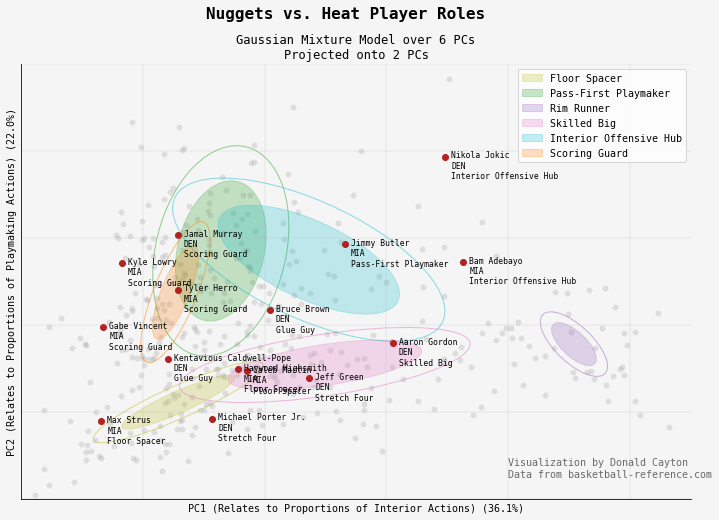

In [145]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

from scipy import linalg
import seaborn as sns

# get avg PC1 and 2 positions for players in 22-23
nba_modern = nba_2[(nba_2["Season"]==2022)&(nba_2.G>20)&(nba_2.MP>10)]
nba_modern_df_cols = ["Player"] + ["Tm"] + ["MP"] + nba_c.columns.tolist()[:-2] + ["Full Role"] 
nba_modern = nba_modern[nba_modern_df_cols]

pca_23 = pca.transform(scaler.transform(nba_modern.iloc[:,3:-1]))
pc1_23 = pca_23[:,0]
pc2_23 = pca_23[:,1]

pc_23_df = pd.DataFrame({"PC1": pc1_23, "PC2": pc2_23, 
                         "Role": nba_modern["Full Role"],
                         "Name": nba_modern.Player,
                         "Team": nba_modern.Tm,
                         "MP": nba_modern.MP
                        })

mpl.rcParams["font.family"]="monospace"
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor("whitesmoke")
ax.set_facecolor("whitesmoke")

ax.grid(linewidth=.2, zorder=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelleft=False, left=False, 
               labelbottom=False, bottom=False)

ax.set_xlabel(f"PC1 (Relates to Proportions of Interior Actions) ({np.round(pca.explained_variance_ratio_[0]*100,1)}%)")
ax.set_ylabel(f"PC2 (Relates to Proportions of Playmaking Actions) ({np.round(pca.explained_variance_ratio_[1]*100,1)}%)")

sns.scatterplot(x="PC1", y="PC2", data=pc_23_df, color="grey", 
                alpha=.2, zorder=1)

colors = ["tab:olive", "tab:green", "tab:purple", "tab:pink", "tab:cyan", "tab:orange"]
cats = ["Floor Spacer", "Pass-First Playmaker", "Rim Runner", "Skilled Big", "Interior Offensive Hub", "Scoring Guard", ]

handles = []
labels = []

for n, color in enumerate(colors):
    covariances = gaussian.covariances_[n][:2, :2]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi
    ell = patches.Ellipse(
        gaussian.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
    )
    ell2 = patches.Ellipse(
        gaussian.means_[n, :2], v[0]*1.5, v[1]*1.5, angle=180 + angle, color=color,
        fill=False
    )
    
    handles += [ell]
    labels += [cats[n]]
                                 
    ell.set_clip_box(ax.bbox)
    ell2.set_clip_box(ax.bbox)
    
    ell.set_alpha(0.25)
    ell2.set_alpha(.5)
    
    ax.add_artist(ell)
    ax.add_artist(ell2)

ax.legend(handles, labels)

heat_nuggets = pc_23_df[(pc_23_df.Team.isin(["MIA", "DEN"])) & (pc_23_df.MP>18) & (pc_23_df.Name!="Victor Oladipo")]

for i, row in heat_nuggets.iterrows():
    ax.scatter(row["PC1"], row["PC2"], color="firebrick")
    ax.annotate(f"{row[3]}\n{row[4]}\n{row[2]}", xy=(row["PC1"], row["PC2"]),
                xytext=(row["PC1"]+.1, row["PC2"]-.5), size=8)
    
ax.set_xlim(-4, 7)
ax.set_ylim(-4, 6)
ax.text(4, -3.5, "Visualization by Donald Cayton\nData from basketball-reference.com", c="dimgrey")
fig.suptitle("Nuggets vs. Heat Player Roles", fontweight="bold", fontsize=16)
plt.title("Gaussian Mixture Model over 6 PCs\nProjected onto 2 PCs", fontsize=12);

In [141]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [142]:
viz_path = parent + "/model_visualizations/gmm_2pcs_nba_cluster"
fig.savefig(viz_path, bbox_inches="tight", dpi=300)

In [81]:
rookies_22 = nba_2[(nba_2.Player.isin(["Paolo Banchero", "Jalen Williams", "Walker Kessler",
                                    "Keegan Murray", "Bennedict Mathurin", "Jaden Ivey",
                                    "Jalen Duren", "Jabari Smith Jr.", "Jeremy Sochan",
                                    "Tari Eason"
                                   ])) & (nba_2.Season==2022) & (nba_2.G>10)].sort_values("MP", ascending=True)
rookies_22 = rookies_22[["Player", "Age", "Tm", "Full Role", "GMM_Primary_Cluster", "GMM_Primary_Cluster_Prob", "GMM_Secondary_Cluster"]]

rookies_22

,Player,Age,Tm,Full Role,GMM_Primary_Cluster,GMM_Primary_Cluster_Prob,GMM_Secondary_Cluster
10186,Tari Eason,21,HOU,Skilled Big,Skilled Big,0.986,None
10311,Walker Kessler,21,UTA,Rim Runner,Rim Runner,1.000,None
10185,Jalen Duren,19,DET,Rim Runner,Rim Runner,0.992,None
10502,Jeremy Sochan,19,SAS,Stretch Four,Skilled Big,0.409,Floor Spacer
10360,Bennedict Mathurin,20,IND,Floor Spacer,Floor Spacer,0.828,None
10399,Keegan Murray,22,SAC,Floor Spacer,Floor Spacer,0.886,None
10563,Jalen Williams,21,OKC,Glue Guy,Pass-First Playmaker,0.569,Skilled Big
10499,Jabari Smith Jr.,19,HOU,Catch-and-Score,Floor Spacer,0.398,Interior Offensive Hub
10278,Jaden Ivey,20,DET,Scoring Guard,Scoring Guard,0.898,None
10070,Paolo Banchero,20,ORL,Interior Offensive Hub,Interior Offensive Hub,0.836,None


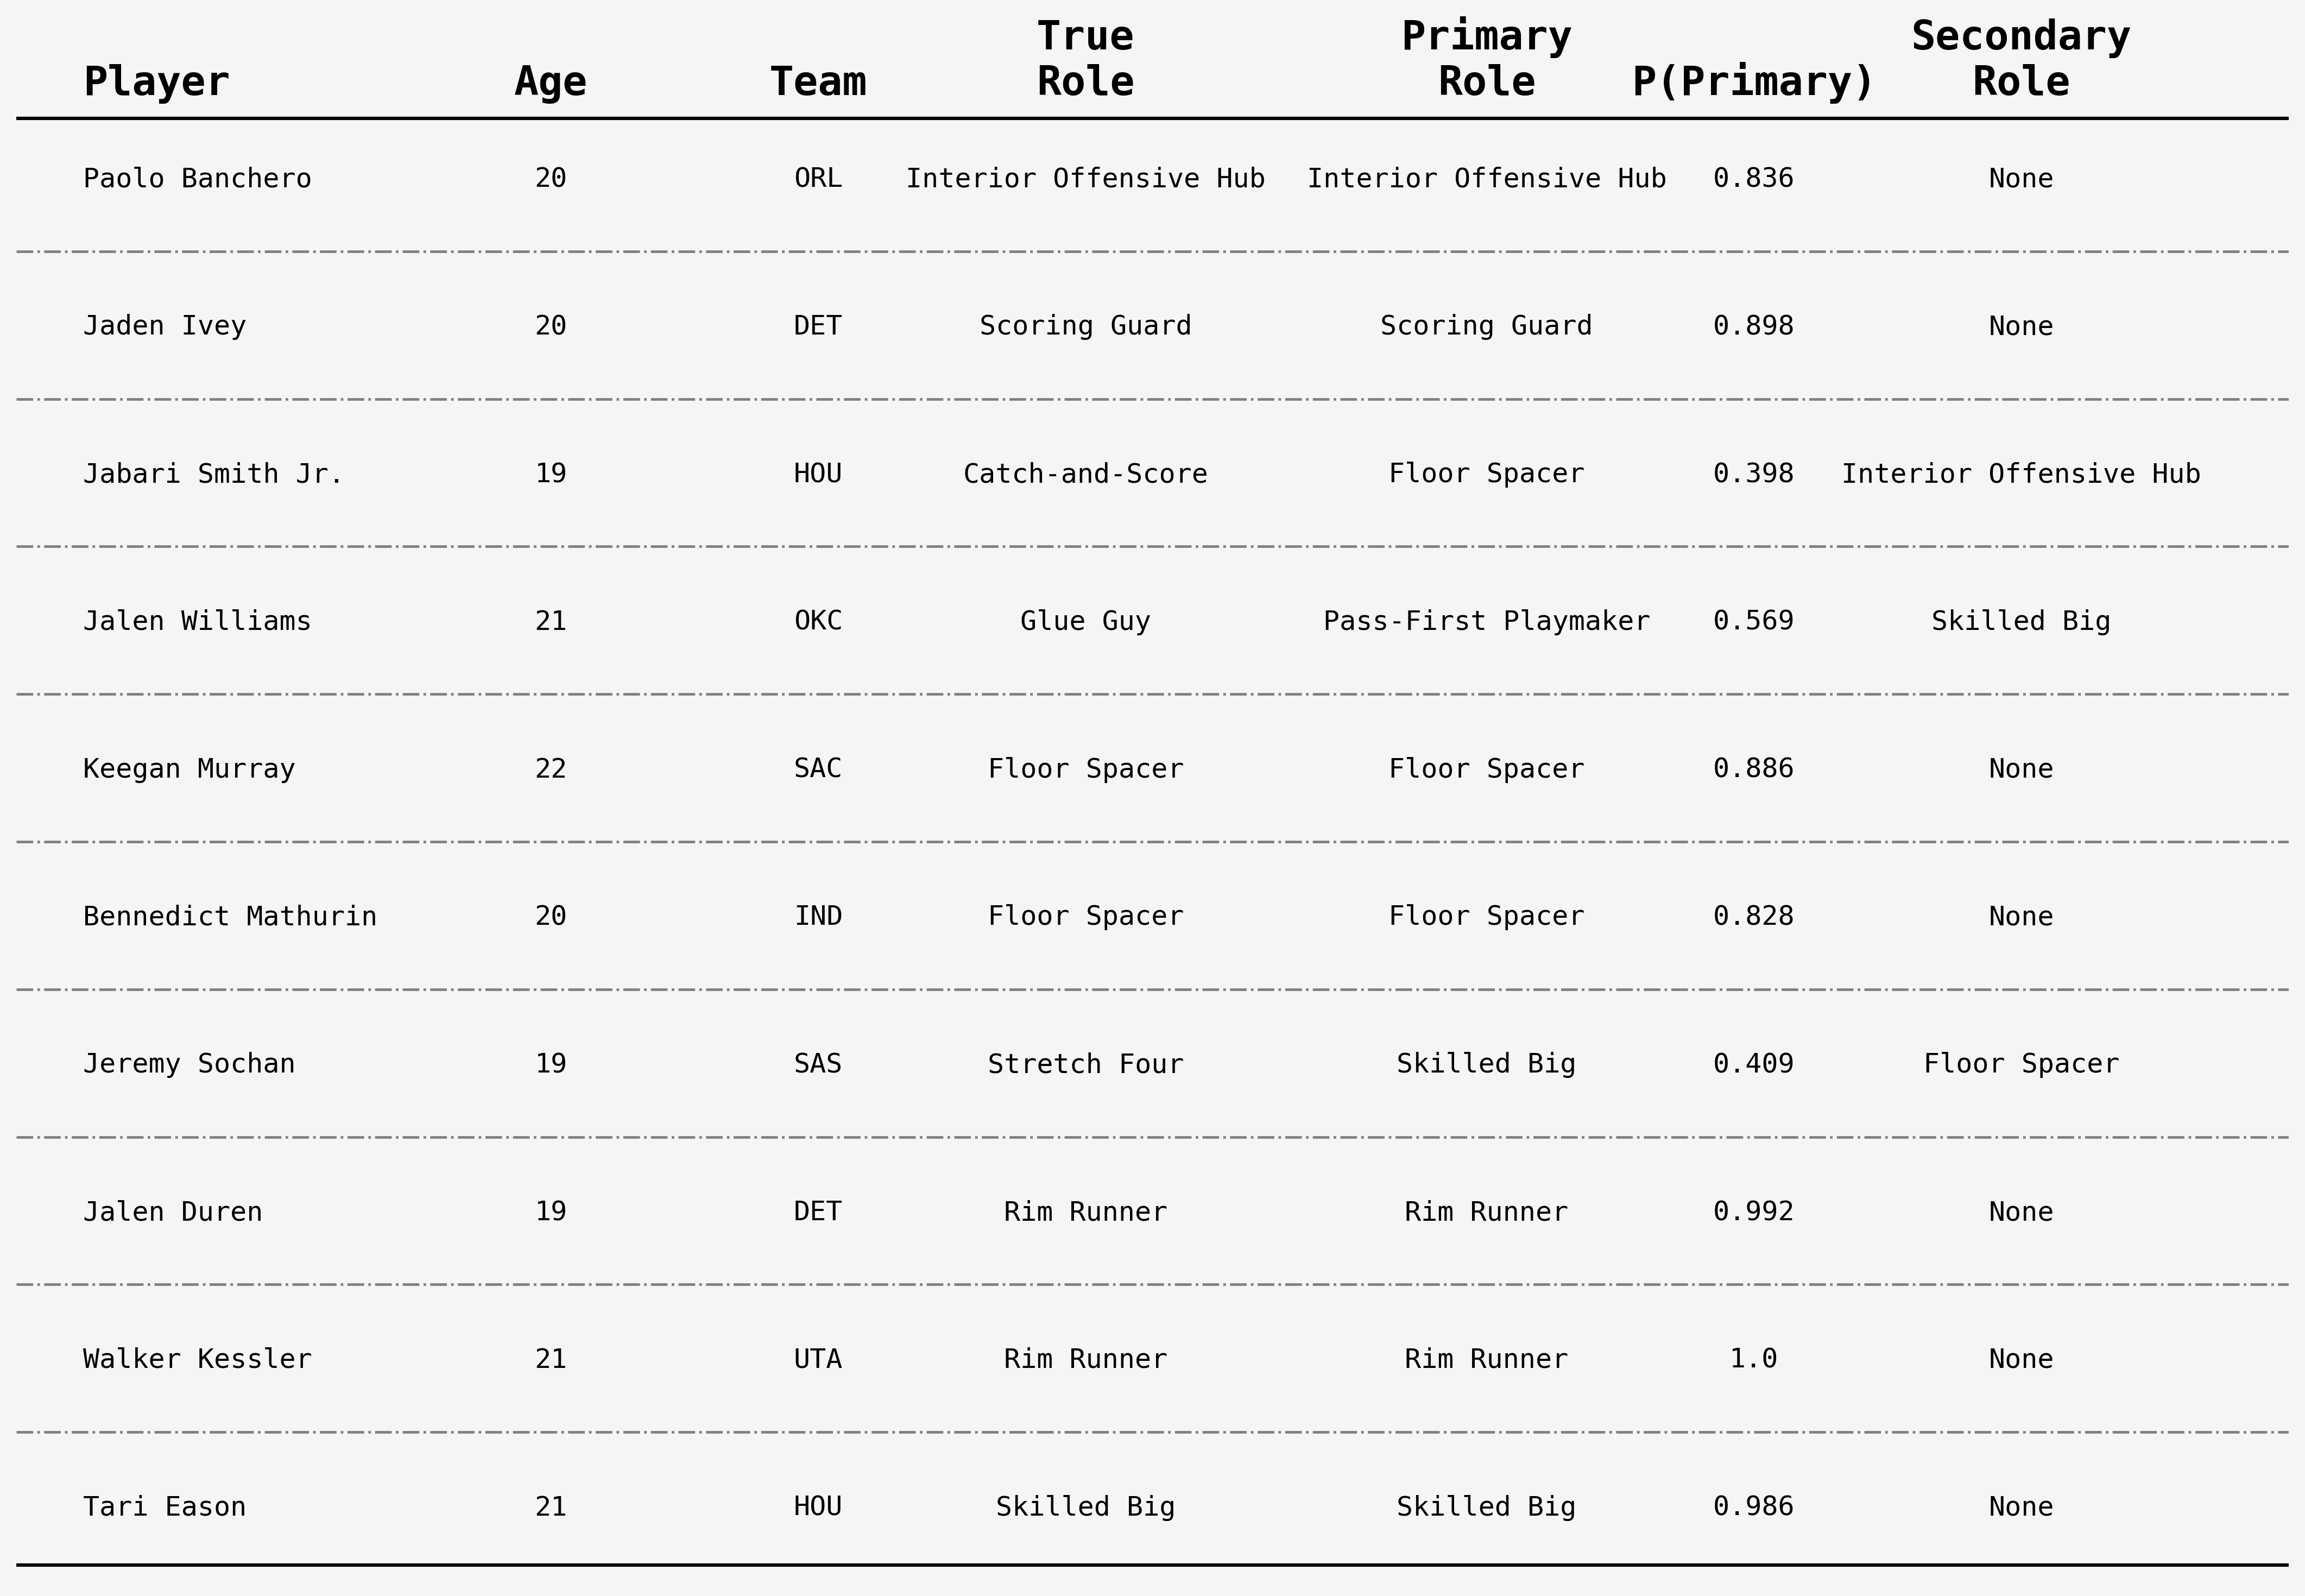

In [129]:
fig = plt.figure(figsize=(18, 12), dpi=300)
ax = plt.subplot()

fig.set_facecolor("whitesmoke")
ax.set_facecolor("whitesmoke")

ncols = rookies_22.shape[1]
nrows = rookies_22.shape[0]

positions = [0.25, 2, 3, 4, 5.5, 6.5, 7.5]
columns = rookies_22.columns

ax.set_xlim(0, max(positions)+1)
ax.set_ylim(0, nrows)

for i in range(nrows):
    for j, column in enumerate(columns):
        if (j == 0):
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[j], i+.4),
            text=rookies_22[column].iloc[i],
            ha=ha,
            va='bottom',
            size=12
        )
        
column_names = ['Player', 'Age', 'Team', 'True\nRole', 'Primary\nRole', 'P(Primary)', 'Secondary\nRole']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold',
            size=18
        )

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows-.1, nrows-.1], lw=1.5, color='black', marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [.1, .1], lw=1.5, color='black', marker='')
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls='dashdot', marker='')
        
ax.set_axis_off()

In [130]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

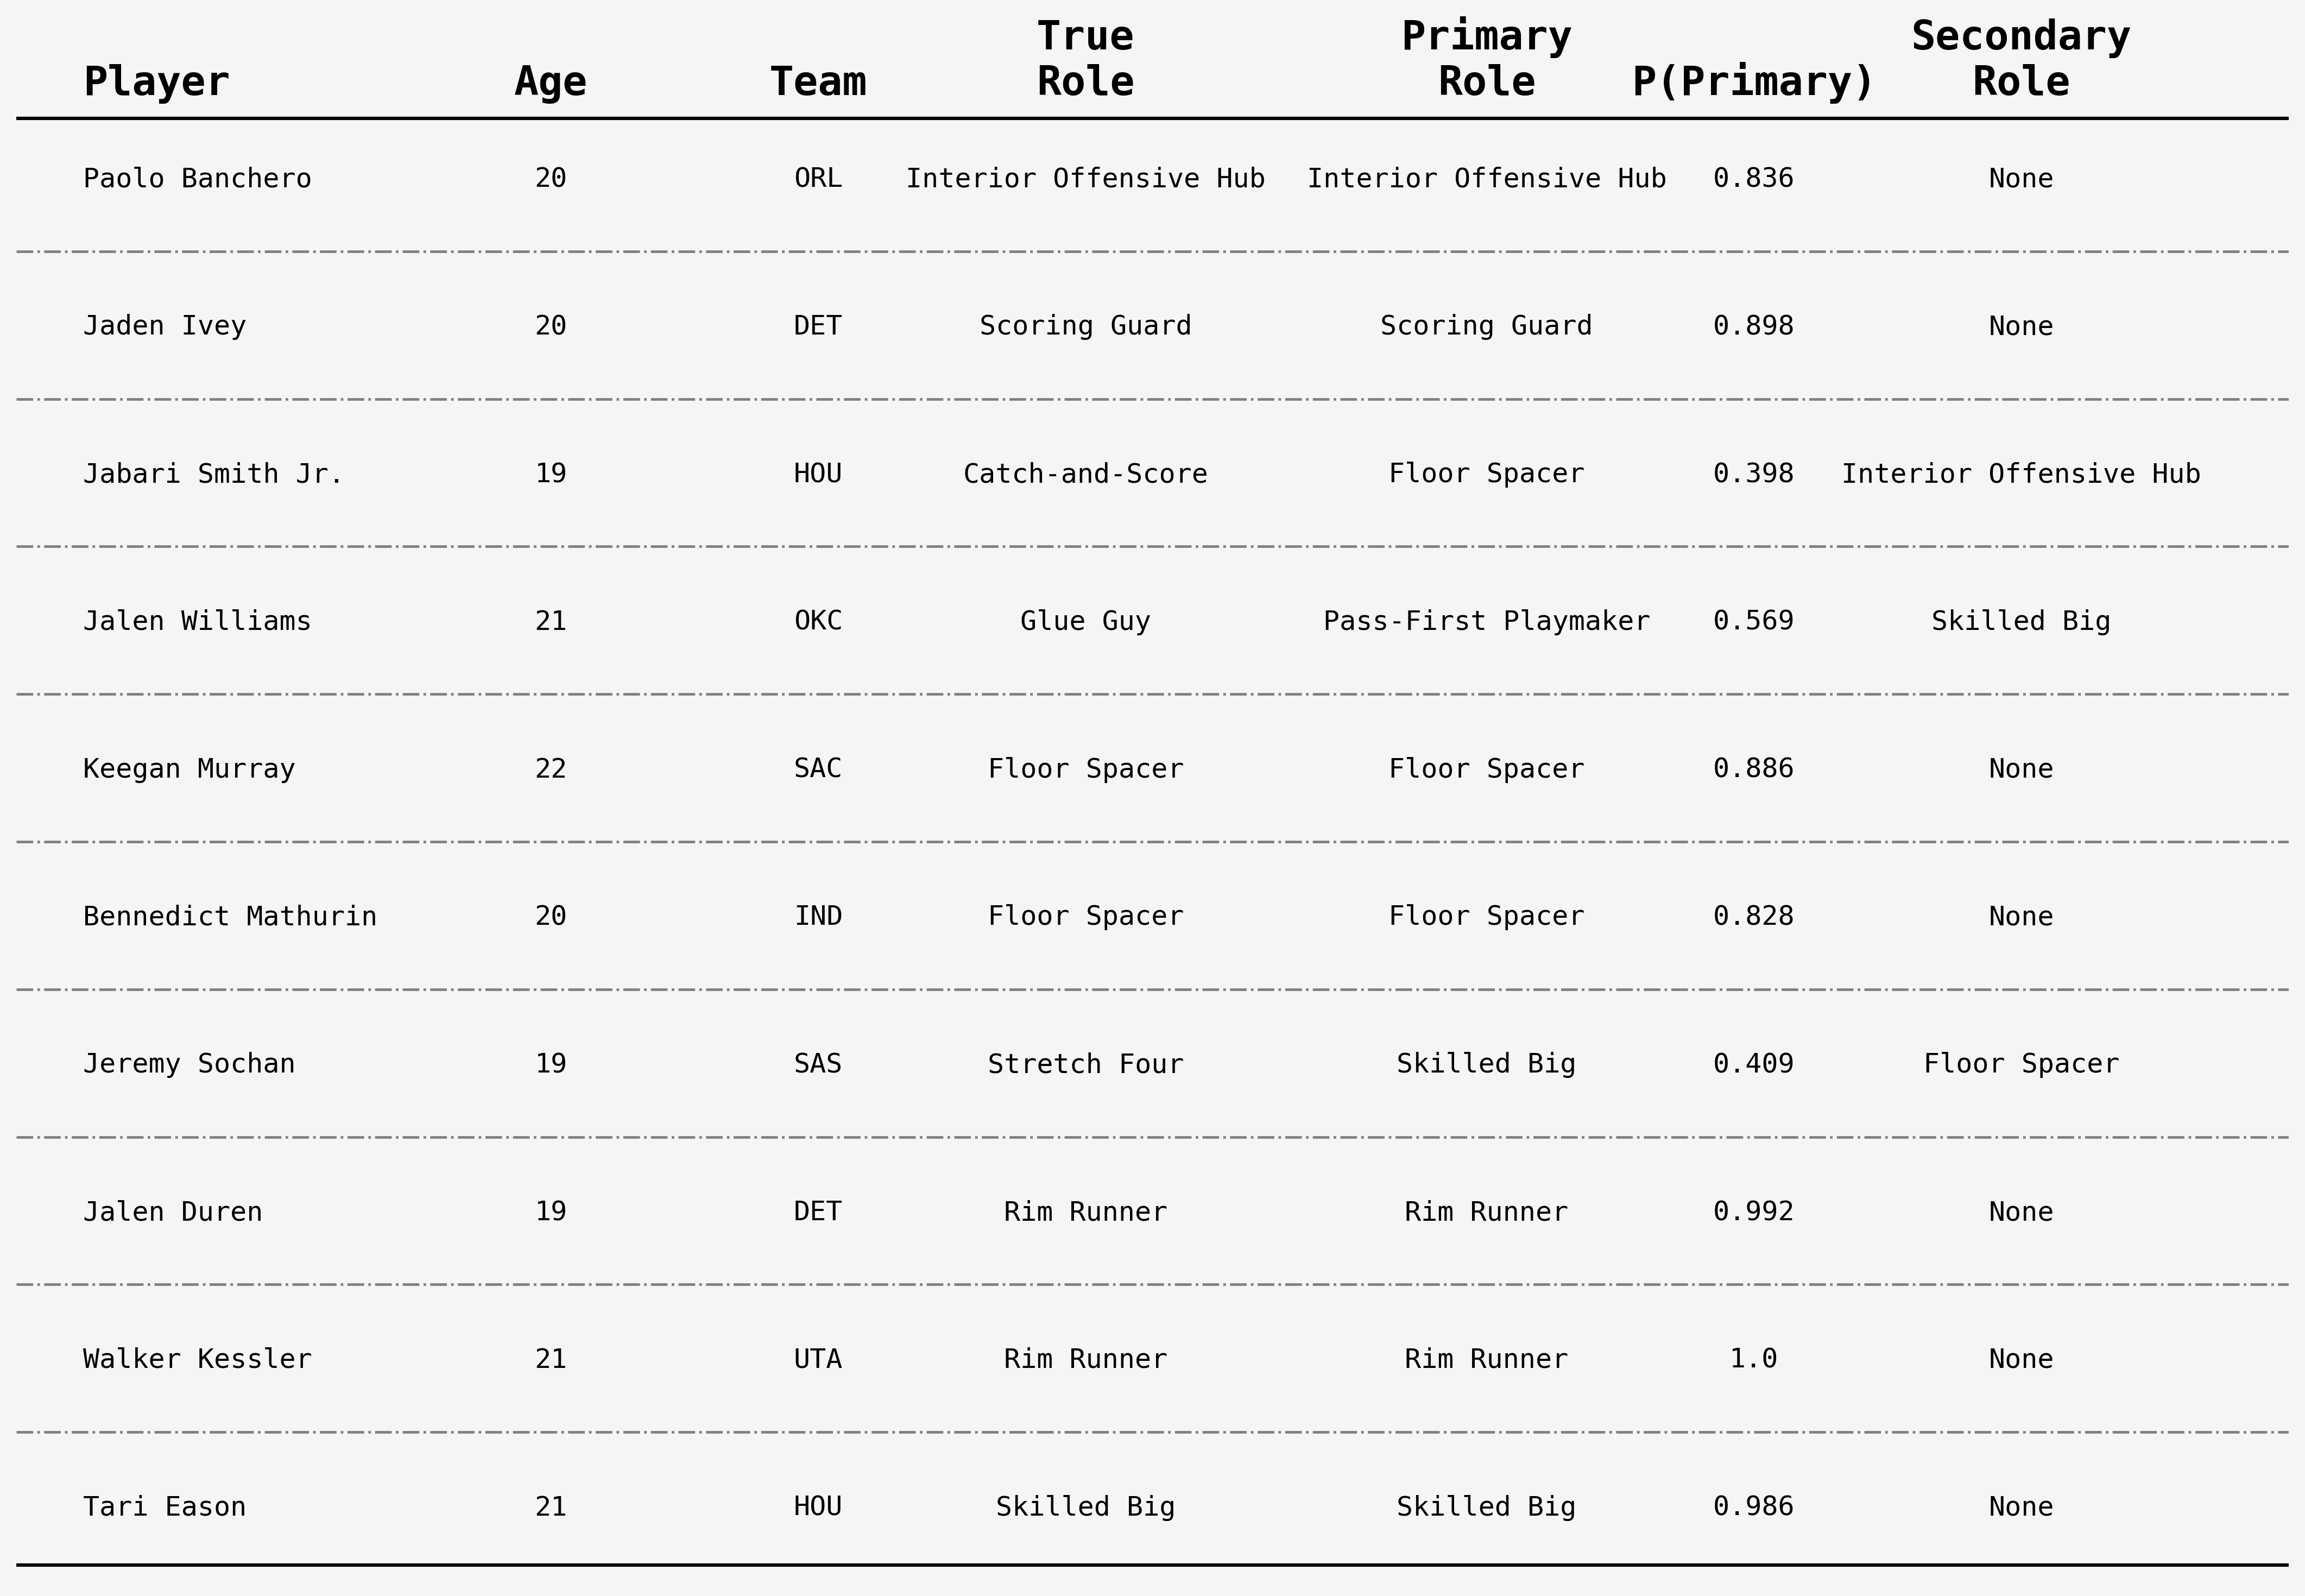

In [131]:
fig

In [132]:
viz_path = parent + "/model_visualizations/all_rookie_table"
fig.savefig(viz_path, bbox_inches="tight", dpi=300)